<a href="https://colab.research.google.com/github/stellaevat/ontology-mapping/blob/main/colabs/load_and_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pronto \
&& wget -O doid.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/EfUC_RdrfZdOsOrtmNATjuoBPDaIkSTUMyxJXyO2KKC6yw?download=1 \
&& wget -O ncit.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/ETmaJIC0fAlItdsp8WQxS_wBzKN_6x08EZrtsOxVnbzvSg?download=1

In [2]:
import pronto
import editdistance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [3]:
ncit = pronto.Ontology("ncit.obo")
doid = pronto.Ontology("doid.obo")

In [263]:
def write_mappings(mappings, filepath):
  with open(filepath, "w") as f:
    for (source_id, target_id) in mappings.items():
      if isinstance(target_id, str):
        f.write(f"{source_id},{target_id}\n")
      else:
        for id in target_id:
          f.write(f"{source_id},{id}\n")

In [264]:
def write_biencoder_sentences(sentences, filepath):
  source_sentences, target_sentences, labels = sentences
  with open(filepath, "w") as f:
    for (source_sentence, target_sentence, label) in zip(source_sentences, target_sentences, labels):
      f.write(f'"{source_sentence}","{target_sentence}","{label}"\n')

# Extract equivalences

In [265]:
def correct_id(id, corrections=[("NCI:", "NCIT:C"), ("NCIT:CC", "NCIT:C")]):
  for (before, after) in corrections:
    id = id.replace(before, after)
  return id

def get_entity_equivalences(source_onto, target_onto, target_code="NCIT:"):
  all_equivalences = {}

  for term in source_onto.terms():
    xref_ids = [correct_id(xref.id) for xref in term.xrefs]
    xref_ids = [id for id in xref_ids if target_code in id and id in target_onto.terms()]
    if len(xref_ids) == 1:
      all_equivalences[correct_id(term.id)] = correct_id(xref_ids[0])

  return all_equivalences

In [266]:
equiv_doid2ncit = get_entity_equivalences(doid, ncit)
equiv_ncit2doid = {v:k for (k,v) in equiv_doid2ncit.items()}
print("Total equivalences: ", len(equiv_doid2ncit))

Total equivalences:  4331


In [267]:
write_mappings(equiv_ncit2doid, "equiv_ncit2doid.csv")

# Derive subsumptions

In [268]:
def get_one_hop_neighbours(term, max_neighbours):
  parents = list(term.superclasses(distance=1, with_self=False))
  children = list(term.subclasses(distance=1, with_self=False))
  neighbours = parents + children

  total_neighbours = len(neighbours)
  if total_neighbours > max_neighbours:
    neighbours = np.random.choice(
        neighbours,
        size=max_neighbours,
        replace=False
    )
  return neighbours, total_neighbours


def get_random_targets(subsumptions, max_targets):
  target_ids = set(subsumptions.values())
  target_counts = {}
  total_count = 0
  for target_id in subsumptions.values():
    target_counts[target_id] = target_counts.get(target_id, 0) + max_targets
    total_count += max_targets

  neg_subsumptions = {}
  for (source_id, target_id) in tqdm(subsumptions.items()):
    choice = list(target_ids - {target_id})
    # Probability of choosing target proportional to how many times it can be used
    probabilities = [target_counts[id] / (total_count - target_counts[target_id]) for id in choice]

    neg_target_ids = choice if len(choice) <= max_targets else np.random.choice(choice, size=max_targets, replace=False, p=probabilities)
    neg_subsumptions[source_id] = neg_target_ids

    for id in neg_target_ids:
      target_counts[id] -= 1
      if target_counts[id] <= 0:
        target_ids.remove(id)

    total_count -= max_targets
  return neg_subsumptions


def get_subsumptions_from_equivalences(equivalences, target_onto, negative=False):
  assert negative in [False, 'random', 'multi', 'neighbours'], "Negative sampling method must be 'random', 'multi' or 'neighbours'."

  np.random.seed(3)
  subsumptions = {}
  target_parent_counts = []
  target_parent_neighbour_counts = []
  target_ids = list(equivalences.values())

  for (source_id, target_id) in tqdm(equivalences.items()):
    if target_id in target_onto.terms():
      target_entity = target_onto.get_term(target_id)
      target_parents = set(target_entity.superclasses(distance=1, with_self=False))
      target_parent_counts.append(len(target_parents))

      # Only keep targets with single parents
      if len(target_parents) == 1:
        target_parent = target_parents.pop()
        if negative == 'neighbours':
          target_parent_neighbours, total_neighbours = get_one_hop_neighbours(target_parent, max_neighbours=10)
          target_parent_neighbour_counts.append(total_neighbours)
          subsumptions[source_id] = [target.id for target in target_parent_neighbours]
        else:
          subsumptions[source_id] = target_parent.id

  if negative == 'random':
    subsumptions = get_random_targets(subsumptions, max_targets=1)
  elif negative == 'multi':
    subsumptions = get_random_targets(subsumptions, max_targets=7)

  print()
  print("Target parent counts: ", Counter(target_parent_counts))
  if negative == 'neighbours':
    print("Target parent neighbour counts: ", Counter(target_parent_neighbour_counts))
  return subsumptions

In [269]:
subs_doid2ncit = get_subsumptions_from_equivalences(equiv_doid2ncit, ncit)
print("Total subsumptions (DOID to NCIT): ", len(subs_doid2ncit))

100%|██████████| 4331/4331 [00:00<00:00, 16090.30it/s]


Target parent counts:  Counter({1: 2210, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total subsumptions (DOID to NCIT):  2210


In [270]:
subs_ncit2doid = get_subsumptions_from_equivalences(equiv_ncit2doid, doid)
print("Total subsumptions (NCIT to DOID): ", len(subs_ncit2doid))

100%|██████████| 4297/4297 [00:00<00:00, 17550.81it/s]


Target parent counts:  Counter({1: 3217, 2: 974, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Total subsumptions (NCIT to DOID):  3217


In [273]:
neg_random_doid2ncit = get_subsumptions_from_equivalences(equiv_doid2ncit, ncit, negative='random')
print("Total (random) negative subsumptions (DOID to NCIT): ", len(neg_random_doid2ncit))

100%|██████████| 2210/2210 [00:01<00:00, 1270.59it/s]


Target parent counts:  Counter({1: 2210, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total (random) negative subsumptions (DOID to NCIT):  2210


In [274]:
neg_random_ncit2doid = get_subsumptions_from_equivalences(equiv_ncit2doid, doid, negative='random')
print("Total (random) negative subsumptions (NCIT to DOID): ", len(neg_random_ncit2doid))

100%|██████████| 3217/3217 [00:02<00:00, 1092.81it/s]


Target parent counts:  Counter({1: 3217, 2: 974, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Total (random) negative subsumptions (NCIT to DOID):  3217


In [275]:
neg_multi_doid2ncit = get_subsumptions_from_equivalences(equiv_doid2ncit, ncit, negative='multi')
print("Total (multiple random) negative subsumptions (DOID to NCIT): ", sum(map(len, neg_multi_doid2ncit.values())))

100%|██████████| 2210/2210 [00:01<00:00, 1514.25it/s]


Target parent counts:  Counter({1: 2210, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Total (multiple random) negative subsumptions (DOID to NCIT):  15468


In [276]:
neg_multi_ncit2doid = get_subsumptions_from_equivalences(equiv_ncit2doid, doid, negative='multi')
print("Total (multiple random) negative subsumptions (DOID to NCIT): ", sum(map(len, neg_multi_ncit2doid.values())))

100%|██████████| 3217/3217 [00:02<00:00, 1156.97it/s]


Target parent counts:  Counter({1: 3217, 2: 974, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Total (multiple random) negative subsumptions (DOID to NCIT):  22519


In [271]:
neg_neighbour_doid2ncit = get_subsumptions_from_equivalences(equiv_doid2ncit, ncit, negative='neighbours')
print("Total (neighbouring) negative subsumptions (DOID to NCIT): ", sum(map(len, neg_neighbour_doid2ncit.values())))

100%|██████████| 4331/4331 [00:02<00:00, 1641.08it/s]


Target parent counts:  Counter({1: 2210, 2: 1701, 3: 356, 4: 50, 5: 13, 6: 1})
Target parent neighbour counts:  Counter({4: 163, 5: 162, 6: 158, 3: 140, 7: 119, 8: 109, 12: 85, 11: 83, 9: 80, 608: 79, 2: 75, 17: 72, 10: 68, 550: 65, 18: 58, 13: 55, 14: 48, 16: 45, 20: 40, 15: 38, 19: 32, 36: 31, 24: 27, 30: 21, 21: 20, 23: 19, 39: 19, 28: 19, 84: 19, 33: 18, 41: 18, 59: 17, 32: 17, 43: 16, 25: 15, 34: 12, 89: 11, 31: 11, 38: 11, 52: 8, 45: 8, 64: 7, 53: 7, 56: 6, 65: 6, 95: 5, 26: 5, 27: 5, 76: 5, 48: 5, 241: 4, 29: 4, 68: 4, 35: 4, 63: 3, 22: 3, 40: 3, 75: 3, 54: 2, 44: 2, 86: 2, 57: 2, 70: 2, 321: 2, 130: 2, 2455: 1, 710: 1, 310: 1, 51: 1, 281: 1, 60: 1})
Total (neighbouring) negative subsumptions (DOID to NCIT):  17445


In [272]:
neg_neighbour_ncit2doid = get_subsumptions_from_equivalences(equiv_ncit2doid, doid, negative='neighbours')
print("Total (neighbouring) negative subsumptions (NCIT to DOID): ", sum(map(len, neg_neighbour_ncit2doid.values())))

100%|██████████| 4297/4297 [00:01<00:00, 3272.44it/s]


Target parent counts:  Counter({1: 3217, 2: 974, 3: 81, 4: 10, 0: 10, 5: 2, 6: 2, 7: 1})
Target parent neighbour counts:  Counter({3: 362, 4: 351, 5: 253, 6: 231, 7: 224, 2: 200, 8: 191, 10: 168, 13: 130, 9: 120, 11: 109, 12: 96, 17: 69, 14: 65, 18: 51, 22: 44, 20: 39, 44: 33, 432: 33, 40: 33, 15: 31, 93: 28, 57: 26, 16: 25, 48: 24, 21: 24, 98: 22, 24: 21, 26: 19, 25: 16, 19: 15, 59: 14, 89: 13, 23: 13, 28: 12, 33: 12, 29: 11, 45: 11, 43: 11, 41: 10, 34: 10, 27: 9, 49: 8, 100: 8, 52: 7, 67: 5, 73: 4, 55: 3, 61: 1, 47: 1, 39: 1})
Total (neighbouring) negative subsumptions (NCIT to DOID):  22567


In [277]:
write_mappings(subs_ncit2doid, "subs_ncit2doid.csv")
write_mappings(neg_random_ncit2doid, "neg_random_ncit2doid.csv")
write_mappings(neg_multi_ncit2doid, "neg_multi_ncit2doid.csv")
write_mappings(neg_neighbour_ncit2doid, "neg_neighbour_ncit2doid.csv")

# Generate sentences

In [278]:
def get_sentence(term_id, term_onto, features=None):
  sep = '[SEP]'
  term = term_onto.get_term(term_id)
  sentence = [term.name]

  if features == 'properties':
    definition = [term.definition] if term.definition else []
    synonyms = [synonym.description for synonym in term.synonyms]
    sentence += definition + synonyms
  elif features == 'parents':
    parents = term.superclasses(distance=1, with_self=False)
    sentence += [parent.name for parent in parents]
  elif features == 'children':
    children = term.subclasses(distance=1, with_self=False)
    sentence += [child.name for child in children]

  sentence = sep.join(sentence)
  return sentence


def get_labelled_biencoder_sentences(subs, neg_subs, source_onto, target_onto, features=None):
  assert features in [None, 'internal', 'external'], "Features included must be 'internal', 'external' or None for just the term itself."
  source_features, target_features = ('parents', 'children') if features == 'external' else (features, features)

  np.random.seed(3)
  source_sentences = []
  target_sentences = []
  labels = []

  pairs = list(subs.items())
  if isinstance(list(neg_subs.values())[0], str):
    neg_pairs = list(neg_subs.items())
  else:
    neg_pairs = [(source_id, target_id) for (source_id, target_ids) in neg_subs.items() for target_id in target_ids]

  ones_and_zeros = [1] * len(pairs) + [0] * len(neg_pairs)
  labelled_pairs = list(zip(ones_and_zeros, pairs + neg_pairs))
  np.random.shuffle(labelled_pairs)

  for label, (source_id, target_id) in tqdm(labelled_pairs):
    if source_id not in source_onto.terms() or target_id not in target_onto.terms():
      continue

    source_sentence = get_sentence(source_id, source_onto, features=source_features)
    target_sentence = get_sentence(target_id, target_onto, features=target_features)
    if source_sentence and target_sentence:
      source_sentences.append(source_sentence)
      target_sentences.append(target_sentence)
      labels.append(label)

  print()
  return source_sentences, target_sentences, labels

In [279]:
sentences_term_random_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_random_ncit2doid, ncit, doid, features=None)
print("Total (term) sentences (NCIT to DOID, random neg. sampling): ", len(sentences_term_random_ncit2doid[0]))

100%|██████████| 6434/6434 [00:00<00:00, 41844.12it/s]


Total (term) sentences (NCIT to DOID, random neg. sampling):  6434


In [280]:
sentences_int_random_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_random_ncit2doid, ncit, doid, features='internal')
print("Total (internal) sentences (NCIT to DOID, random neg. sampling): ", len(sentences_int_random_ncit2doid[0]))

100%|██████████| 6434/6434 [00:00<00:00, 41518.18it/s]


Total (internal) sentences (NCIT to DOID, random neg. sampling):  6434


In [281]:
sentences_ext_random_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_random_ncit2doid, ncit, doid, features='external')
print("Total (external) sentences (NCIT to DOID, random neg. sampling): ", len(sentences_ext_random_ncit2doid[0]))

100%|██████████| 6434/6434 [00:02<00:00, 3157.00it/s]


Total (external) sentences (NCIT to DOID, random neg. sampling):  6434


In [282]:
sentences_term_multi_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_multi_ncit2doid, ncit, doid, features=None)
print("Total (term) sentences (NCIT to DOID, multi neg. sampling): ", len(sentences_term_multi_ncit2doid[0]))

100%|██████████| 25736/25736 [00:00<00:00, 37619.92it/s]


Total (term) sentences (NCIT to DOID, multi neg. sampling):  25736


In [283]:
sentences_int_multi_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_multi_ncit2doid, ncit, doid, features='internal')
print("Total (internal) sentences (NCIT to DOID, multi neg. sampling): ", len(sentences_int_multi_ncit2doid[0]))

100%|██████████| 25736/25736 [00:00<00:00, 40390.24it/s]


Total (internal) sentences (NCIT to DOID, multi neg. sampling):  25736


In [284]:
sentences_ext_multi_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_multi_ncit2doid, ncit, doid, features='external')
print("Total (external) sentences (NCIT to DOID, multi neg. sampling): ", len(sentences_ext_multi_ncit2doid[0]))

100%|██████████| 25736/25736 [00:10<00:00, 2529.85it/s]


Total (external) sentences (NCIT to DOID, multi neg. sampling):  25736


In [285]:
sentences_term_neighbour_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_neighbour_ncit2doid, ncit, doid, features=None)
print("Total (term) sentences (NCIT to DOID, neighbour neg. sampling): ", len(sentences_term_neighbour_ncit2doid[0]))

100%|██████████| 25784/25784 [00:00<00:00, 39058.13it/s]


Total (term) sentences (NCIT to DOID, neighbour neg. sampling):  25784


In [286]:
sentences_int_neighbour_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_neighbour_ncit2doid, ncit, doid, features='internal')
print("Total (internal) sentences (NCIT to DOID, neighbour neg. sampling): ", len(sentences_int_neighbour_ncit2doid[0]))

100%|██████████| 25784/25784 [00:00<00:00, 36309.16it/s]


Total (internal) sentences (NCIT to DOID, neighbour neg. sampling):  25784


In [287]:
sentences_ext_neighbour_ncit2doid = get_labelled_biencoder_sentences(subs_ncit2doid, neg_neighbour_ncit2doid, ncit, doid, features='external')
print("Total (external) sentences (NCIT to DOID, neighbour neg. sampling): ", len(sentences_ext_neighbour_ncit2doid[0]))

100%|██████████| 25784/25784 [00:06<00:00, 4274.97it/s]


Total (external) sentences (NCIT to DOID, neighbour neg. sampling):  25784


In [288]:
write_biencoder_sentences(sentences_term_random_ncit2doid, "sentences_term_random_ncit2doid.csv")
write_biencoder_sentences(sentences_int_random_ncit2doid, "sentences_int_random_ncit2doid.csv")
write_biencoder_sentences(sentences_ext_random_ncit2doid, "sentences_ext_random_ncit2doid.csv")
write_biencoder_sentences(sentences_term_multi_ncit2doid, "sentences_term_multi_ncit2doid.csv")
write_biencoder_sentences(sentences_int_multi_ncit2doid, "sentences_int_multi_ncit2doid.csv")
write_biencoder_sentences(sentences_ext_multi_ncit2doid, "sentences_ext_multi_ncit2doid.csv")
write_biencoder_sentences(sentences_term_neighbour_ncit2doid, "sentences_term_neighbour_ncit2doid.csv")
write_biencoder_sentences(sentences_int_neighbour_ncit2doid, "sentences_int_neighbour_ncit2doid.csv")
write_biencoder_sentences(sentences_ext_neighbour_ncit2doid, "sentences_ext_neighbour_ncit2doid.csv")

In [289]:
# from transformers import AutoTokenizer
# term_id = "DOID:0014667"
# tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

# sentence = get_sentence(term_id, doid, features='children')
# tokenized = tokenizer(sentence)

# print(sentence)
# tokenizer.convert_ids_to_tokens(tokenized['input_ids'])

# String difference

## Equivalences

In [290]:
str_equivalences = {doid.get_term(source).name.lower() : ncit.get_term(target).name.lower() for (source, target) in all_equivalences.items() if source in doid.terms() and target in ncit.terms()}

distances = np.array([editdistance.eval(source, target) for (source, target) in str_equivalences.items()])
lengths = np.array([max(len(source), len(target)) for (source, target) in str_equivalences.items()])
normalised = np.round(distances / lengths, decimals=2)

dist_distribution = Counter(distances)
norm_distribution = Counter(normalised)

Distances: [(0, 2384), (1, 95), (2, 126), (3, 50), (4, 114), (5, 84), (6, 66), (7, 93), (8, 139), (9, 72), (10, 77), (11, 70), (12, 43), (13, 59), (14, 64), (15, 70), (16, 75), (17, 52), (18, 82), (19, 40), (20, 51), (21, 37), (22, 33), (23, 42), (24, 31), (25, 34), (26, 28), (27, 20), (28, 11), (29, 22), (30, 7), (31, 12), (32, 10), (33, 19), (34, 19), (35, 14), (36, 7), (37, 9), (38, 4), (39, 5), (40, 9), (41, 2), (42, 7), (43, 3), (44, 5), (45, 4), (46, 5), (47, 3), (48, 2), (49, 1), (50, 6), (51, 1), (52, 1), (53, 2), (54, 1), (55, 4), (58, 2), (59, 1), (82, 1), (95, 1)]
Median: 0.0, Mean: 6.25, STD: 10.02


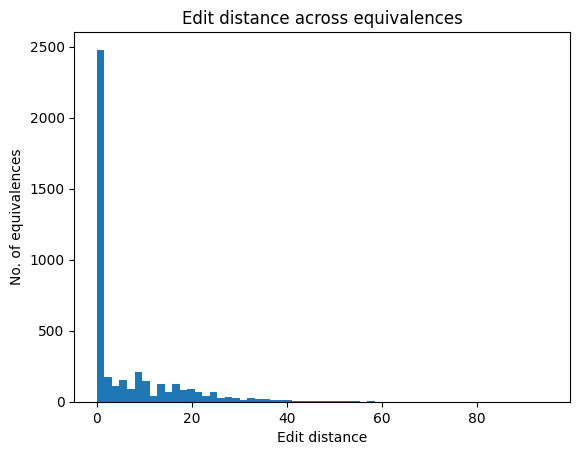

In [291]:
plt.hist(distances, bins=len(dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of equivalences")
plt.title("Edit distance across equivalences")
print("Distances:", sorted(dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(distances)}, Mean: {np.mean(distances):.2f}, STD: {np.std(distances):.2f}")

Text(0.5, 1.0, 'Edit distance across equivalences (0s excluded)')

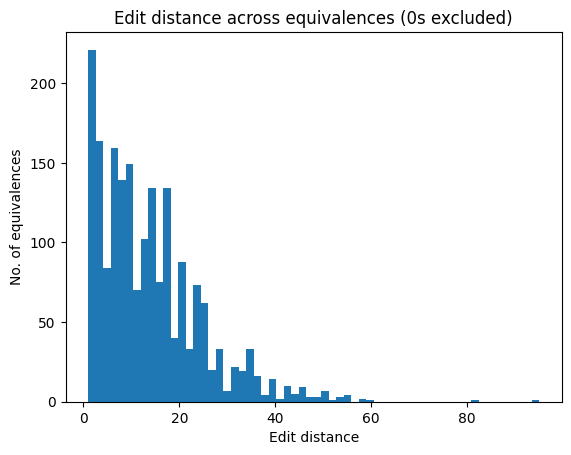

In [292]:
plt.hist(distances[distances != 0], bins=len(dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of equivalences")
plt.title("Edit distance across equivalences (0s excluded)")

Normalised: [(0.0, 2384), (0.01, 1), (0.02, 11), (0.03, 31), (0.04, 23), (0.05, 21), (0.06, 19), (0.07, 31), (0.08, 24), (0.09, 20), (0.1, 21), (0.11, 17), (0.12, 28), (0.13, 9), (0.14, 32), (0.15, 24), (0.16, 28), (0.17, 33), (0.18, 20), (0.19, 27), (0.2, 24), (0.21, 31), (0.22, 20), (0.23, 30), (0.24, 36), (0.25, 28), (0.26, 17), (0.27, 39), (0.28, 27), (0.29, 35), (0.3, 22), (0.31, 32), (0.32, 36), (0.33, 44), (0.34, 9), (0.35, 28), (0.36, 28), (0.37, 15), (0.38, 39), (0.39, 17), (0.4, 26), (0.41, 22), (0.42, 25), (0.43, 29), (0.44, 25), (0.45, 14), (0.46, 19), (0.47, 27), (0.48, 24), (0.49, 8), (0.5, 31), (0.51, 10), (0.52, 29), (0.53, 22), (0.54, 14), (0.55, 20), (0.56, 25), (0.57, 27), (0.58, 22), (0.59, 22), (0.6, 20), (0.61, 17), (0.62, 26), (0.63, 14), (0.64, 17), (0.65, 14), (0.66, 13), (0.67, 17), (0.68, 23), (0.69, 12), (0.7, 16), (0.71, 14), (0.72, 15), (0.73, 14), (0.74, 14), (0.75, 18), (0.76, 15), (0.77, 22), (0.78, 12), (0.79, 32), (0.8, 19), (0.81, 22), (0.82, 18), (0

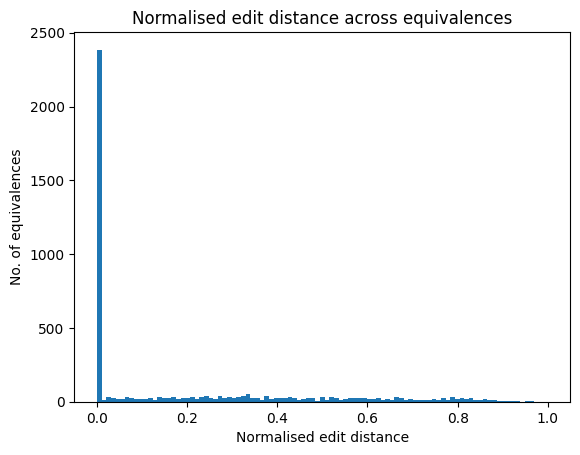

In [293]:
plt.hist(normalised, bins=len(norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of equivalences")
plt.title("Normalised edit distance across equivalences")
print("Normalised:", sorted(norm_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(normalised)}, Mean: {np.mean(normalised):.2f}, STD: {np.std(normalised):.2f}")

Text(0.5, 1.0, 'Normalised edit distance across equivalences (0s excluded)')

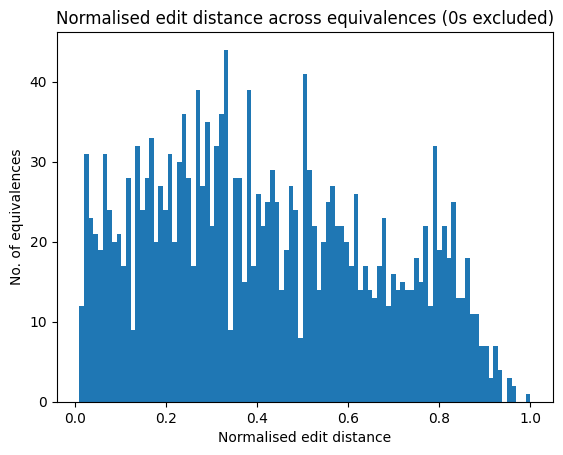

In [294]:
plt.hist(normalised[normalised != 0], bins=len(norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of equivalences")
plt.title("Normalised edit distance across equivalences (0s excluded)")

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff82a153b50>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff82a1740d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff82a1538b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff82a174610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff82a1748b0>],
 'means': []}

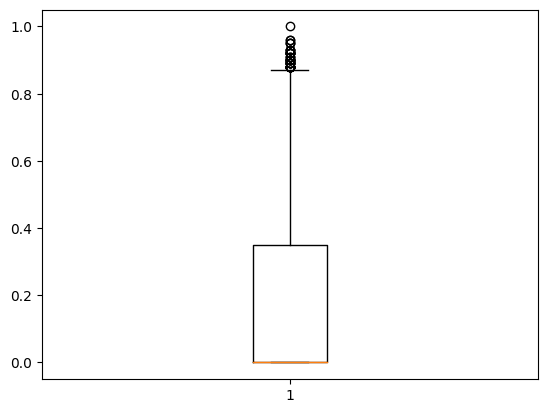

In [295]:
plt.boxplot(normalised)

In [296]:
print("Equivalences with distinct terms:\n")

count = 0
for (source, target) in str_equivalences.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    count += 1
    if count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{count} out of {len(str_equivalences)} ({(100 * count/len(str_equivalences)):.1f}%) are distinct")

Equivalences with distinct terms:

gne myopathy -> nonaka myopathy
immunodeficiency 11b -> immunodeficiency 11b with atopic dermatitis
mediastinum neuroblastoma -> mediastinal neuroblastoma
blood coagulation disease -> coagulation disorder
hemangioma of subcutaneous tissue -> subcutaneous hemangioma
maxillary sinus benign neoplasm -> maxillary sinus neoplasm
systemic primary carnitine deficiency disease -> primary carnitine deficiency
sympathetic neurilemmoma -> sympathetic schwannoma
bartter disease -> bartter syndrome
seminal vesicle tumor -> seminal vesicle neoplasm
gastrointestinal adenoma -> digestive system adenoma
adult endodermal sinus tumor -> adult yolk sac tumor
refractory hematologic cancer -> refractory hematologic malignancy
childhood supratentorial ependymoma -> childhood supratentorial ependymoma, not otherwise specified
hilar lung neoplasm -> lung hilum neoplasm
apocrine adenosis of breast -> breast apocrine adenosis
central breast papilloma -> breast central papilloma

## Subsumptions

In [297]:
str_subsumptions = {doid.get_term(source).name.lower() : ncit.get_term(target).name.lower() for (source, target) in doid_to_ncit_subs.items() if source in doid.terms() and target in ncit.terms()}

sub_distances = np.array([editdistance.eval(source, target) for (source, target) in str_subsumptions.items()])
sub_lengths = np.array([max(len(source), len(target)) for (source, target) in str_subsumptions.items()])
sub_normalised = np.round(sub_distances / sub_lengths, decimals=2)

sub_dist_distribution = Counter(sub_distances)
sub_norm_distribution = Counter(sub_normalised)

Distances: [(0, 11), (1, 1), (2, 5), (3, 5), (4, 14), (5, 30), (6, 54), (7, 60), (8, 97), (9, 99), (10, 104), (11, 102), (12, 101), (13, 87), (14, 93), (15, 76), (16, 80), (17, 76), (18, 60), (19, 55), (20, 74), (21, 52), (22, 55), (23, 66), (24, 58), (25, 46), (26, 42), (27, 28), (28, 21), (29, 28), (30, 31), (31, 21), (32, 24), (33, 22), (34, 11), (35, 9), (36, 11), (37, 8), (38, 10), (39, 8), (40, 8), (41, 3), (42, 7), (43, 1), (44, 7), (45, 7), (46, 3), (47, 4), (48, 4), (49, 1), (52, 1), (53, 1), (54, 1)]
Median: 16.0, Mean: 17.34, STD: 9.08


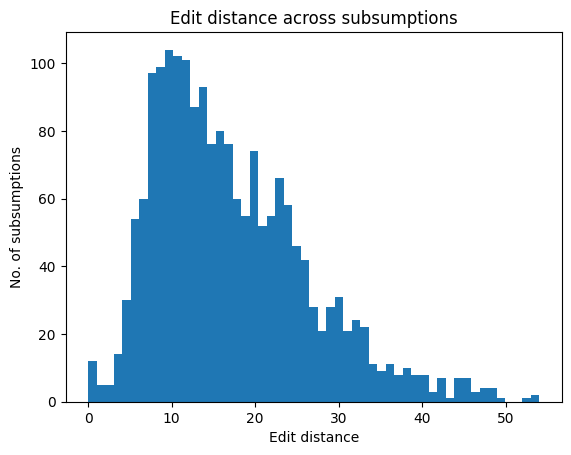

In [298]:
plt.hist(sub_distances, bins=len(sub_dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of subsumptions")
plt.title("Edit distance across subsumptions")
print("Distances:", sorted(sub_dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(sub_distances)}, Mean: {np.mean(sub_distances):.2f}, STD: {np.std(sub_distances):.2f}")

Normalised: [(0.0, 11), (0.07, 1), (0.08, 1), (0.09, 1), (0.11, 2), (0.14, 2), (0.15, 2), (0.16, 1), (0.17, 6), (0.18, 4), (0.19, 4), (0.2, 3), (0.21, 6), (0.22, 5), (0.23, 9), (0.24, 7), (0.25, 11), (0.26, 9), (0.27, 8), (0.28, 8), (0.29, 13), (0.3, 14), (0.31, 22), (0.32, 13), (0.33, 25), (0.34, 10), (0.35, 27), (0.36, 25), (0.37, 14), (0.38, 24), (0.39, 26), (0.4, 25), (0.41, 21), (0.42, 28), (0.43, 33), (0.44, 31), (0.45, 35), (0.46, 20), (0.47, 27), (0.48, 25), (0.49, 6), (0.5, 67), (0.51, 7), (0.52, 31), (0.53, 34), (0.54, 21), (0.55, 34), (0.56, 48), (0.57, 28), (0.58, 22), (0.59, 24), (0.6, 23), (0.61, 22), (0.62, 28), (0.63, 13), (0.64, 21), (0.65, 26), (0.66, 13), (0.67, 31), (0.68, 26), (0.69, 17), (0.7, 33), (0.71, 34), (0.72, 14), (0.73, 22), (0.74, 33), (0.75, 34), (0.76, 26), (0.77, 29), (0.78, 34), (0.79, 83), (0.8, 41), (0.81, 51), (0.82, 43), (0.83, 48), (0.84, 47), (0.85, 37), (0.86, 41), (0.87, 19), (0.88, 28), (0.89, 27), (0.9, 11), (0.91, 7), (0.92, 8), (0.93, 11)

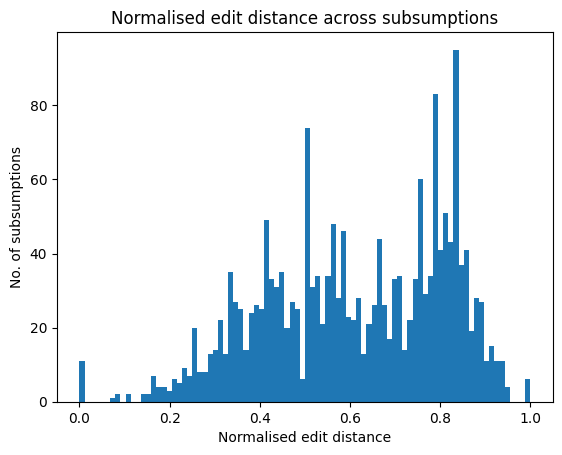

In [299]:
plt.hist(sub_normalised, bins=len(sub_norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of subsumptions")
plt.title("Normalised edit distance across subsumptions")
print("Normalised:", sorted(sub_norm_distribution.items(), key=lambda x:x[0]))

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff829f68250>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff829f68790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff829f53f70>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff829f68cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff829f68f70>],
 'means': []}

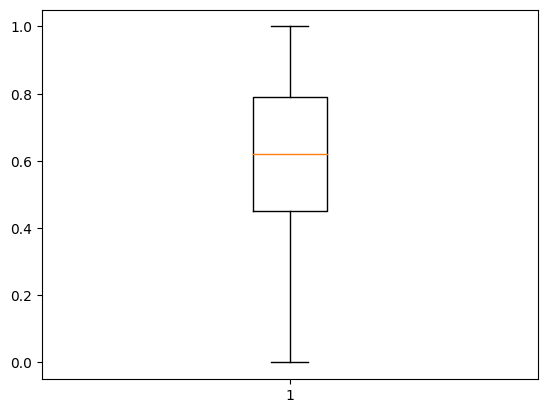

In [300]:
plt.boxplot(sub_normalised)

In [301]:
print("Subsumptions with distinct terms:\n")

sub_count = 0
for (source, target) in str_subsumptions.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    sub_count += 1
    if sub_count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{sub_count} out of {len(str_subsumptions)} ({(100 * sub_count/len(str_subsumptions)):.1f}%) are distinct")

Subsumptions with distinct terms:

high-grade b-cell lymphoma double-hit/triple-hit -> high grade b-cell lymphoma with myc and bcl2 and/or bcl6 rearrangements
mixed mineral dust pneumoconiosis -> pneumoconiosis
methemoglobinemia -> non-neoplastic hematologic and lymphocytic disorder
arachnoiditis -> central nervous system infectious disorder
migraine without aura -> migraine
nocardiosis -> bacterial infection
addison's disease -> primary adrenal insufficiency
farmer's lung -> pneumonitis
junctional epidermolysis bullosa -> epidermolysis bullosa
achondroplasia -> non-neoplastic bone disorder
proliferative glomerulonephritis -> glomerulonephritis
clear cell basal cell carcinoma -> skin basal cell carcinoma
pancreatic cholera -> ectopic hormone secretion syndrome associated with neoplasia
osteosarcoma arising in bone paget's disease -> secondary osteosarcoma
sphenoorbital meningioma -> skull base meningioma
vaginal tubulovillous adenoma -> vaginal adenoma
bullous pemphigoid -> pemphigoid


In [302]:
source_contained = np.array([1 if source in target else 0 for (source, target) in str_subsumptions.items()])
target_contained = np.array([1 if target in source else 0 for (source, target) in str_subsumptions.items()])

source_contained_distribution = Counter(source_contained)
target_contained_distribution = Counter(target_contained)

Source contained in 17 out of 1883 (0.9%)


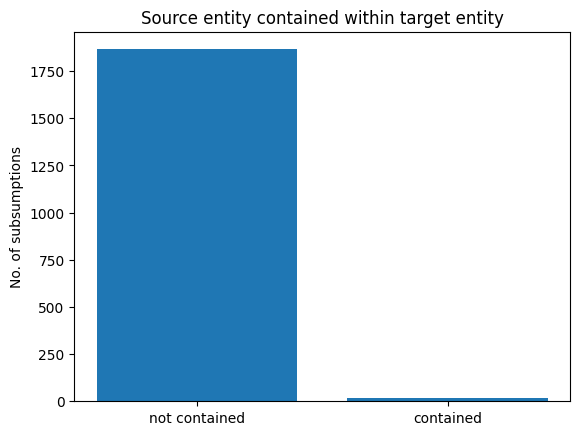

In [303]:
plt.bar(["not contained", "contained"], [len(source_contained)-np.sum(source_contained), np.sum(source_contained)])
plt.ylabel("No. of subsumptions")
plt.title("Source entity contained within target entity")
print(f"Source contained in {source_contained_distribution[1]} out of {len(source_contained)} ({100*source_contained_distribution[1]/len(source_contained):.1f}%)")

Target contained in 513 out of 1883 (27.2%)


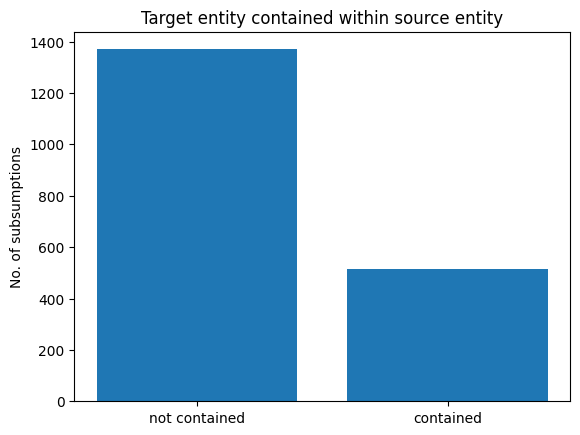

In [304]:
plt.bar(["not contained", "contained"], [len(target_contained)-np.sum(target_contained), np.sum(target_contained)])
plt.ylabel("No. of subsumptions")
plt.title("Target entity contained within source entity")
print(f"Target contained in {target_contained_distribution[1]} out of {len(target_contained)} ({100*target_contained_distribution[1]/len(target_contained):.1f}%)")

## Negative mappings

In [305]:
str_nsubsumptions = {doid.get_term(source).name.lower() : ncit.get_term(target).name.lower() for (source, target) in neg_doid_to_ncit_subs.items() if source in doid.terms() and target in ncit.terms()}

nsub_distances = np.array([editdistance.eval(source, target) for (source, target) in str_nsubsumptions.items()])
nsub_lengths = np.array([max(len(source), len(target)) for (source, target) in str_nsubsumptions.items()])
nsub_normalised = np.round(nsub_distances / nsub_lengths, decimals=2)

nsub_dist_distribution = Counter(nsub_distances)
nsub_norm_distribution = Counter(nsub_normalised)

NameError: name 'neg_doid_to_ncit_subs' is not defined

In [ ]:
plt.hist(nsub_distances, bins=len(nsub_dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of negative subsumptions")
plt.title("Edit distance across negative subsumptions")
print("Distances:", sorted(nsub_dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(nsub_distances)}, Mean: {np.mean(nsub_distances):.2f}, STD: {np.std(nsub_distances):.2f}")

In [ ]:
plt.hist(nsub_normalised, bins=len(nsub_norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of negative subsumptions")
plt.title("Normalised edit distance across negative subsumptions")
print("Normalised:", sorted(nsub_norm_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(nsub_normalised)}, Mean: {np.mean(nsub_normalised):.2f}, STD: {np.std(nsub_normalised):.2f}")

In [ ]:
plt.boxplot(nsub_normalised)

In [ ]:
print("Negative subsumptions with distinct terms:\n")

nsub_count = 0
for (source, target) in str_nsubsumptions.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    nsub_count += 1
    if nsub_count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{nsub_count} out of {len(str_nsubsumptions)} ({(100 * nsub_count/len(str_nsubsumptions)):.1f}%) are distinct")

In [ ]:
nsource_contained = np.array([1 if source in target else 0 for (source, target) in str_nsubsumptions.items()])
ntarget_contained = np.array([1 if target in source else 0 for (source, target) in str_nsubsumptions.items()])

nsource_contained_distribution = Counter(nsource_contained)
ntarget_contained_distribution = Counter(ntarget_contained)

In [ ]:
plt.bar(["not contained", "contained"], [len(nsource_contained)-np.sum(nsource_contained), np.sum(nsource_contained)])
plt.ylabel("No. of negative subsumptions")
plt.title("Source entity contained within negative target entity")
print(f"Source contained in {nsource_contained_distribution[1]} out of {len(nsource_contained)} ({100*nsource_contained_distribution[1]/len(nsource_contained):.1f}%)")

In [ ]:
plt.bar(["not contained", "contained"], [len(ntarget_contained)-np.sum(ntarget_contained), np.sum(ntarget_contained)])
plt.ylabel("No. of negative subsumptions")
plt.title("Negative target entity contained within source entity")
print(f"Target contained in {ntarget_contained_distribution[1]} out of {len(ntarget_contained)} ({100*ntarget_contained_distribution[1]/len(ntarget_contained):.1f}%)")